## IBM Applied Data Science Capstone Project : Week 3 (part 3)

In [95]:
# clear out the environment
% reset -f

In [97]:
# setup the notebook with initial data and wrangling

import pandas as pd

# Get the HTML information
rawinfo = pd.read_html ("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M", header=0)

# Convert to a dataframe with 3 columns : Toronto Neighborhoods (tn)
tn = rawinfo[0]

# remove rows with 'Borough' equal 'Not Assigned'
mask = tn['Borough'].isin(['Not assigned'])
tn = tn[~mask]

# reset the index now that 'Borough = Not assigned' rows have been removed
tn.reset_index(inplace=True)

# drop the original 'index'
tn = tn.drop('index', axis=1)

# rename 'Postcode' to 'PostalCode' to match the example
tn.rename (columns={'Postcode':'PostalCode'}, inplace=True)

# combine neighbourhoods in the same postal code
tn = tn.groupby(['PostalCode', 'Borough'], sort = False).agg(lambda x: ', '.join(x))

# add index back in
tn.reset_index(inplace=True)

In [98]:
# handle 'Neighbourhood' = 'Not assigned' even though there is a 'Borough'
for index, row in tn.iterrows():
   if row.Neighbourhood == 'Not assigned':
        tn.loc[index, 'Neighbourhood'] = tn.loc[index, 'Borough']

In [99]:
print(tn.shape)

(103, 3)


### Part 2 starts here:

In [100]:
# Get the Latitude and Longitude information
geoinfo = pd.read_csv ("http://cocl.us/Geospatial_data", header=0)

In [101]:
# rename 'Postal Code' to 'PostalCode' in order to merge
geoinfo.rename (columns={"Postal Code":"PostalCode"}, inplace=True)

In [102]:
# combine tn dataframe ('PostalCode', 'Borough' and 'Neighbourhood') with geoinfo ('Latitude' and 'Longitude')
tn_geo = tn.merge (geoinfo, on='PostalCode')

In [104]:
tn_geo.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


### Part 3 starts here:

In [105]:
import numpy as np   # library to handle data in a vectorized manner
from geopy.geocoders import Nominatim  # convert an address into latitude and longitude values

# Mabplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium

# for HTTP requests
import json
import requests
from pandas.io.json import json_normalize #transform JSON file into Pandas DataFrame


Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge


### Create a map of Toronto with neighborhoods superimposed on top
The geographical coordinate of Toronto, Canada are 43.6532, -79.3832

In [106]:
latitude = 43.6532
longitude = -79.3832
map_toronto = folium.Map (location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip (tn_geo['Latitude'], tn_geo['Longitude'], tn_geo['Borough'], tn_geo['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup (label, parse_html=True)
    folium.CircleMarker(
       [lat, lng],
       radius=5,
       popup=label,
       color='blue',
       fill=True,
       fill_color='#3186cc',
       fill_opacity=0.7,
       parse_html=False).add_to(map_toronto)

In [107]:
# Here is a map of all Toronto Neighborhoods - no clustering yet
map_toronto

In [108]:
# Will take the suggestion to only work with Borough's that contain the name 'Toronto'
toronto_borough_only = tn_geo[tn_geo['Borough'].isin(['Downtown Toronto', 'East Toronto', 'West Toronto', 'Central Toronto'])].reset_index(drop=True)
toronto_borough_only

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564
7,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568
8,M6H,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259
9,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752


In [109]:
# Now, create a map of Toronto area boroughs that only include 'Toronto' in the name (using latitude and longitude values)
map_toronto_only = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_borough_only['Latitude'], toronto_borough_only['Longitude'], toronto_borough_only['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_only)  
    
map_toronto_only

In [110]:
# The code was removed by Watson Studio for sharing.

In [112]:
# function that extracts the category of the venue
def get_category_type (row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
    if len (categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

The next cell is a hidden cell and my not be shown. It contains a call to the Foursquare API and that requires Client_id and Client_secret (which should not be shared).

In [115]:
# The code was removed by Watson Studio for sharing.

In [116]:
# store values for Neighborhood, Latitude and Longitude for only Boroughs that have 'Toronto' in the name
toronto_venues = getNearbyVenues (names=toronto_borough_only['Neighbourhood'],
                                 latitudes=toronto_borough_only['Latitude'],
                                 longitudes=toronto_borough_only['Longitude'])

Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
The Danforth West, Riverdale
Design Exchange, Toronto Dominion Centre
Brockton, Exhibition Place, Parkdale Village
The Beaches West, India Bazaar
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North, Forest Hill West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Moore Park, Summerhill East
Chinatown, Grange Park, Kensington Market
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
Fir

In [117]:
print (toronto_venues.shape)

(1694, 7)


In [118]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",19,19,19,19,19,19
Business Reply Mail Processing Centre 969 Eastern,19,19,19,19,19,19
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",47,47,47,47,47,47
Central Bay Street,83,83,83,83,83,83
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,15,15,15,15,15,15


In [119]:
print ('There are {} unique categories.'.format (len(toronto_venues['Venue Category'].unique())))

There are 235 unique categories.


## 3. Analyze Each Neighborhood

In [120]:
# one hot encoding
toronto_onehot = pd.get_dummies (toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
# to review the one_hot_encoding
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,...,0.00000,0.00,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.052632
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,0.142857,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012048,...,0.00000,0.00,0.012048,0.000000,0.012048,0.000000,0.012048,0.000000,0.00,0.012048
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.050000,0.000000,0.000000,0.050000,0.010000,0.000000,0.00,0.000000
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,Church and Wellesley,0.011628,0.011628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011628,...,0.00000,0.00,0.000000,0.011628,0.000000,0.011628,0.000000,0.011628,0.00,0.011628


In [123]:
toronto_grouped.shape

(38, 236)

In [124]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print ("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':2})
    print (temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print ('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2  American Restaurant  0.04
3      Thai Restaurant  0.04
4           Steakhouse  0.04


----Berczy Park----
            venue  freq
0     Coffee Shop  0.07
1      Restaurant  0.05
2    Cocktail Bar  0.05
3  Farmers Market  0.04
4     Cheese Shop  0.04


----Brockton, Exhibition Place, Parkdale Village----
            venue  freq
0  Breakfast Spot  0.11
1     Coffee Shop  0.11
2            Café  0.11
3             Gym  0.05
4             Bar  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0  Light Rail Station  0.11
1          Restaurant  0.05
2          Smoke Shop  0.05
3         Pizza Place  0.05
4                 Spa  0.05


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0  Airport Terminal  0.14
1    Airport Lounge  0.14
2   A

In [125]:
def return_most_common_venues (row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [126]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append ('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame (columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
    
neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,American Restaurant,Thai Restaurant,Clothing Store,Asian Restaurant,Restaurant,Hotel,Bar
1,Berczy Park,Coffee Shop,Restaurant,Cocktail Bar,Café,Beer Bar,Italian Restaurant,Bakery,Steakhouse,Seafood Restaurant,Cheese Shop
2,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Coffee Shop,Café,Performing Arts Venue,Burrito Place,Stadium,Bar,Caribbean Restaurant,Italian Restaurant,Climbing Gym
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Recording Studio,Smoke Shop,Skate Park,Brewery,Burrito Place,Butcher,Restaurant,Comic Shop
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Airport Terminal,Plane,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Boat or Ferry


## 4. Cluster Neighborhoods

Run k-means to cluster the neighborhood into 'k' clusters

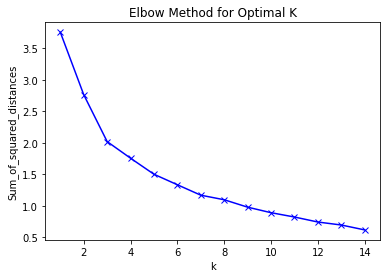

In [127]:
# Will first determine the optimal value of 'k' by using the 'elbow method'
toronto_grouped_clustering = toronto_grouped.drop ('Neighbourhood', 1)
import matplotlib.pyplot as plt
%matplotlib inline

Sum_of_squared_distances = []
K = range (1,15)
for k in K:
    km = KMeans (n_clusters=k)
    km = km.fit (toronto_grouped_clustering)
    Sum_of_squared_distances.append (km.inertia_)

plt.plot (K, Sum_of_squared_distances, 'bx-')
plt.xlabel ('k')
plt.ylabel ('Sum_of_squared_distances')
plt.title ('Elbow Method for Optimal K')
plt.show()

In [128]:
# set number of clusters - based on the results of the 'elbow method' above
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop ('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans (n_clusters=kclusters, random_state=0).fit (toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
# kmeans.labels_[0:10]
print (kmeans.labels_)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 0 2 2 0 1 2 2 2 2 2 2 2 2
 2]


In [129]:
# add clustering labels
neighborhoods_venues_sorted.insert (0, 'Cluster Labels', kmeans.labels_)

print (neighborhoods_venues_sorted.head(10))
toronto_merged = toronto_borough_only

# 
# 'Cluster Labels' will show as 'float' because of 'NaN' in tn_geo combined with doing a default 'how' merge of left'
# changed 'how' 'inner' and that keeps out the 'NaN'
# 5, 52 and 95 don't have venues. That makes 'Cluster Labels' 'NaN' and the turns it into 'float' values
# how to determine if no info was received from Foursquare API call (i.e. for 5, 52 and 95)?

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how='inner')
# the above gives shape (100,16)

# toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how='left')
# the above gives shape (103,16)

print (toronto_merged.shape)


   Cluster Labels                                      Neighbourhood  \
0               2                           Adelaide, King, Richmond   
1               2                                        Berczy Park   
2               2       Brockton, Exhibition Place, Parkdale Village   
3               2  Business Reply Mail Processing Centre 969 Eastern   
4               2  CN Tower, Bathurst Quay, Island airport, Harbo...   
5               2                        Cabbagetown, St. James Town   
6               2                                 Central Bay Street   
7               2          Chinatown, Grange Park, Kensington Market   
8               2                                           Christie   
9               2                               Church and Wellesley   

  1st Most Common Venue 2nd Most Common Venue  3rd Most Common Venue  \
0           Coffee Shop                  Café             Steakhouse   
1           Coffee Shop            Restaurant           Cocktai

Let's visualize the resulting clusters

In [130]:
# create map showing Boroughs with 'Toronto' in the name, with a different color for each cluster
map_clusters = folium.Map (location=[latitude, longitude], zoom_start=10)

# set the color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range (kclusters)]
colors_array = cm.rainbow (np.linspace (0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip (toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup (str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=3,
    popup=label,
    color=rainbow[cluster-1],
    fill=True,
    fill_color=rainbow[cluster-1],
    fill_opacity=0.7).add_to(map_clusters)

map_clusters

In [132]:
# Cluster 0 seems focused on Parks (looking at 1st and 2nd Most Common Venues)
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Lawrence Park,0,Park,Swim School,Dim Sum Restaurant,Bus Line,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
20,"Forest Hill North, Forest Hill West",0,Park,Trail,Sushi Restaurant,Jewelry Store,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
28,"Moore Park, Summerhill East",0,Playground,Park,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
32,Rosedale,0,Park,Playground,Trail,Yoga Studio,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


In [133]:
# Cluster 1 seems focused on Gardens (looking at 1st Most Common Venue)
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Roselawn,1,Garden,Yoga Studio,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [134]:
# Cluster 3 is the largest cluster. It seems focused on Coffee Shop / Food (looking at 1st and 2nd Most Common Venues)
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Harbourfront, Regent Park",2,Coffee Shop,Bakery,Café,Pub,Park,Theater,Mexican Restaurant,Breakfast Spot,Restaurant,Electronics Store
1,"Ryerson, Garden District",2,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Tea Room,Japanese Restaurant,Italian Restaurant,Diner,Pizza Place
2,St. James Town,2,Coffee Shop,Restaurant,Café,Hotel,Clothing Store,Breakfast Spot,Cocktail Bar,Park,Cosmetics Shop,Bakery
3,The Beaches,2,Coffee Shop,Pub,Neighborhood,Yoga Studio,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
4,Berczy Park,2,Coffee Shop,Restaurant,Cocktail Bar,Café,Beer Bar,Italian Restaurant,Bakery,Steakhouse,Seafood Restaurant,Cheese Shop
5,Central Bay Street,2,Coffee Shop,Café,Italian Restaurant,Burger Joint,Bar,Chinese Restaurant,Thai Restaurant,Salad Place,Bubble Tea Shop,Spa
6,Christie,2,Café,Grocery Store,Park,Baby Store,Diner,Italian Restaurant,Nightclub,Restaurant,Coffee Shop,Convenience Store
7,"Adelaide, King, Richmond",2,Coffee Shop,Café,Steakhouse,American Restaurant,Thai Restaurant,Clothing Store,Asian Restaurant,Restaurant,Hotel,Bar
8,"Dovercourt Village, Dufferin",2,Bakery,Pharmacy,Supermarket,Gym / Fitness Center,Pool,Music Venue,Discount Store,Café,Middle Eastern Restaurant,Brewery
9,"Harbourfront East, Toronto Islands, Union Station",2,Coffee Shop,Hotel,Aquarium,Café,Pizza Place,Italian Restaurant,Bakery,Scenic Lookout,Restaurant,Brewery


This is the end of the notebook.